In [1]:
import numpy as np
import math
import pylab as plt
import collections
import scipy
from scipy import special, interpolate

* 1-D advection equation

$\frac{\partial u}{\partial t}(x,t)+\frac{\partial u}{\partial x}(x,t) = 0, \quad x\in [0,1], t \geq 0$

I.C.: $u(x,0)=\exp^{-2\cos(2\pi x)}$

Sol: $u(x,t)=\exp^{-2\cos(2\pi(x-t))}$

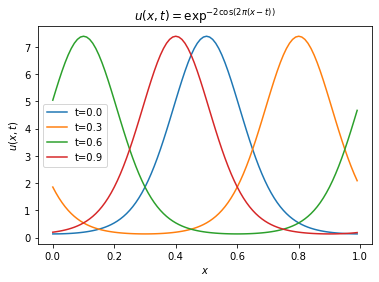

In [2]:
#analytical solution
def AnalyticSolution(x,t):
    return np.exp(-2*np.cos(2*np.pi*(x-t)))

x_max=1.
x_min=0.
x=np.linspace(x_min,x_max,100,endpoint=False)

#make plots
for t in [0.,0.3, 0.6, 0.9]:
    plt.plot(x,AnalyticSolution(x,t),label='t=%.1f'%t)
    
plt.title('$u(x,t)=\exp^{-2\cos(2\pi(x-t))}$')
plt.ylabel('$u(x,t)$')
plt.xlabel('$x$')
plt.legend()
plt.show()

# 1. finite-difference method

In [3]:
#setup

def Setup_FD(N):
    """Performs the necessary setup for FD evolution 
    on N grid points
    
    returns 
        t, u, info
    
    where
      - t=0.  the initial time
      - u the solution at t=0 (i.e. the initial data)
      - info a tuple containing
         - info.dxmin minimal grid-spacing
         - info.x an array of grid-points"""
         
    # storage for extra info
    FD_Info_t=collections.namedtuple('FD_Info_t', 'dxmin, x')
    x = np.linspace(x_min, x_max, N, endpoint=False)
    info=FD_Info_t(dxmin=(x_max-x_min)/N, x=x)
    #print("dxmin=",info.dxmin) # dxmin (required to compute dt from CF)
    #print("x =",info.x) # all grid points (useful for plots)
    u = AnalyticSolution(x, 0.)
    return 0., u, info

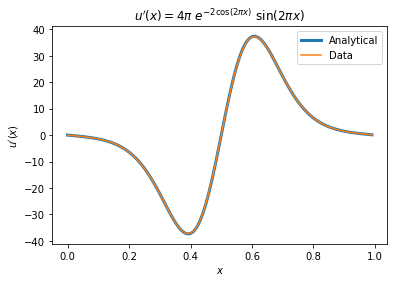

In [4]:
#Task FD-1

def calc_F(t,u,info):
    """Computes RHS F[u(x,t)] of the advection equation
    using 2nd order centered FD with periodic BCs."""
    
    N=len(u)
    #h=(x_max-x_min)/N
    #du=np.zeros(N)
    du=u.copy()
    
    du[0]=(u[1]-u[N-1])
    for ii in range(1,N-1):
        du[ii]=(u[ii+1]-u[ii-1])
    du[N-1]=(u[0]-u[N-2])
    
    du/=(2*info.dxmin)
    return -du

#plt.figure(figsize=(10,5))

#check for u(x)=sin(2\pi x)
#u=np.sin(2*np.pi*x)
#dudt = F(0,u)
 

#plt.subplot(121)
#plt.plot(x,2*np.pi*np.cos(2*np.pi*x),label='Analytical',linewidth=2)
#plt.plot(x,dudt,label='Data')
#plt.legend()
#plt.title(r'$2\pi~\cos(2\pi x)$')
##plt.show()

#check for u(x)=e^(-2cos(2\pi x))
t,u,info=Setup_FD(100)

plt.plot(info.x,-4*np.pi*np.exp(-2*np.cos(2*np.pi*info.x))*np.sin(2*np.pi*info.x),label='Analytical',linewidth=3)
plt.plot(info.x,calc_F(t,u,info),label='Data')
plt.legend()
plt.title(r'$u^\prime(x)=4\pi~e^{-2\cos(2\pi x)}~\sin(2\pi x)$')
plt.xlabel('$x$')
plt.ylabel(r'$u^\prime(x)$')
plt.show()

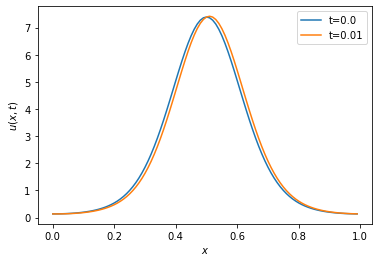

In [5]:
#Task FD-2

def FE_Step(t,u,F,dt,info):
    """Perform one Forward Euler step
    
       - t current time
       - u current solution
       - F function that computes the right-hand-side 'F' in 
            du/dt = F
         The caling sequence is F(t, u, info)
       - dt time-step
       - info extra information needed by the right-hand-side function 
       
    returns
       t_new, u_new
       """
    u_new=u + dt*F(t,u,info)
    return t+dt, u_new

t,u,info=Setup_FD(100)
t_new,u_new=FE_Step(t,u,calc_F,0.01,info)

plt.plot(info.x,u,label='t=0.0')
plt.plot(info.x,u_new,label='t=%.2f'%t_new)
plt.xlabel('$x$')
plt.ylabel('$u(x,t)$')
plt.legend()
plt.show()

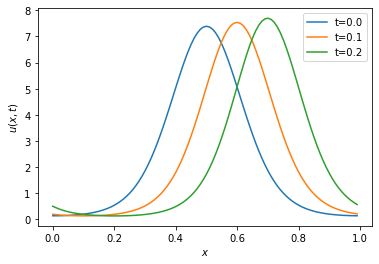

In [6]:
#Task FD-3

def Evolve(t, t_final, u, F, Tstepper, CF, info):
    
    """Evolve the evolution equations represented by right-hand-side ’F’
    with time-stepper Tstepper until final time ’T_final’.
    
    t - current time
    t_final - final time
    u - solution at current time ’t’
    F - A function computing the right-hand-side of the
    evolution equations. Calling sequence: F(t, u, info)
    Tstepper - A function that performs one time-step.
    Calling sequence: Tstepper(t, u, F, dt, info)
    CF - courant-factor; ’Evolve’ will choose a timestep dt
    that satisfies dt < CF*dxmin
    info - a namedtuple with any additional information needed by
    ’F’ or ’Tstepper’. Specifically, ’info.dxmin’ must
    return the minimal grid-spacing. ’info’ is passed
    into ’TStepper’ and ’F’. These two functions can either
    ignore ’info’, or retrieve any information from there
    that they need.
    
    returns
    t_final, u_final"""
    
    # time-step
    dt = CF*info.dxmin
    Nsteps=int(np.ceil((t_final-t)/dt))  # round up number of steps
    dt = (t_final-t)/Nsteps           # adjust dt to precisely reach t_final
    for i in range(Nsteps):
        t, u = Tstepper(t, u, F, dt, info)
    return t, u


t,u,info=Setup_FD(100)
plt.plot(info.x,u,label='t=0.0')
for t_final in [0.1,0.2]:
    t,u=Evolve(t,t_final,u,calc_F,FE_Step,1/2,info)
    plt.plot(info.x,u,label='t=%.1f'%t)
plt.xlabel('$x$')
plt.ylabel('$u(x,t)$')
plt.legend()
plt.show()

N= 20
N= 40
N= 80
N= 160
N= 320
N= 640


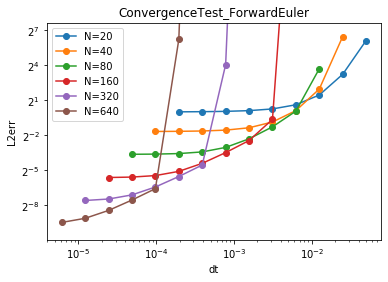

In [44]:
#Task FD-4 *convergence test*

t_final=1.
errN={}  # error at fixed N  vs. CF

for N in [20, 40, 80, 160, 320, 640]:
    print("N=",N)
    errN[N]=[[], []]
    for CF in [0, -1, -2, -3, -4, -5, -6, -7, -8]:
        t,u0,info = Setup_FD(N)
        t,u=Evolve(t,t_final,u0,calc_F,FE_Step,2**CF,info)
        # L2-norm of error after advecting once through domain
        err=np.sqrt(np.dot(u-u0, u-u0)/N)
        errN[N][0].append(2**CF*info.dxmin)  # store time-step
        errN[N][1].append(err)            # store error
    plt.loglog(errN[N][0], errN[N][1], 'o-', basey=2., basex=10, label="N=%d"%N)  # plot!
plt.xlabel('dt')
plt.ylabel('L2err')
plt.title("ConvergenceTest_ForwardEuler")
plt.legend()
plt.ylim(5e-4, 2e2)
plt.show()

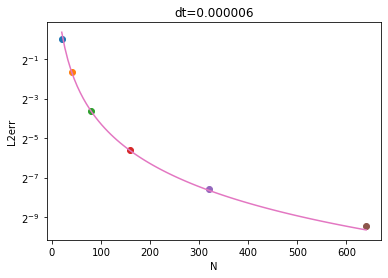

In [299]:
#checks
for N in [20, 40, 80, 160, 320, 640]:
    plt.semilogy(N,errN[N][1][-1],'o-',basey=2)
grid=np.linspace(20,640,100)
plt.semilogy(grid,2**9*grid**(-2),basey=2)
plt.title("dt=%f"%errN[N][0][-1])
plt.xlabel('N')
plt.ylabel('L2err')
plt.show()

N= 20
N= 40
N= 80
N= 160
N= 320
N= 640


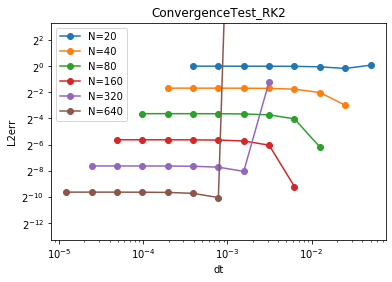

In [300]:
#Task FD-5

def RK2_Step(t, u, F, dt, info):
    """"Perform one Runge-Kutta 2 step
    
       - t current time
       - u current solution
       - F function that computes the right-hand-side 'F' in 
            du/dt = F
         The caling sequence is F(t, u, info)
       - dt time-step
       - info extra information needed by the right-hand-side function 
         
    returns
       t_new, u_new
    """

    k1=dt*F(t, u, info)
    k2=dt*F(t+0.5*dt, u+0.5*k1, info)
    return (t+dt, u+k2)

t_final=1.
errN={}  # error at fixed N  vs. CF
for N in [20, 40, 80, 160, 320, 640]:
    print("N=",N)
    errN[N]=[[], []]
    for CF in [0, -1, -2, -3, -4, -5, -6, -7]:
        t, u0, info = Setup_FD(N)
        t,u=Evolve(t,t_final,u0,calc_F,RK2_Step,2**CF,info)
        # L2-norm of error after advecting once through domain
        err=np.sqrt(np.dot(u-u0, u-u0)/N)
        errN[N][0].append(2**CF*info.dxmin)  # store time-step
        errN[N][1].append(err)            # store error
    plt.loglog(errN[N][0], errN[N][1], 'o-', basey=2., basex=10, label="N=%d"%N)  # plot!
plt.xlabel('dt')
plt.ylabel('L2err')
plt.title("ConvergenceTest_RK2")
plt.legend()
plt.ylim(1e-4, 10.)
plt.show()

N= 20
N= 40
N= 80
N= 160
N= 320
N= 640


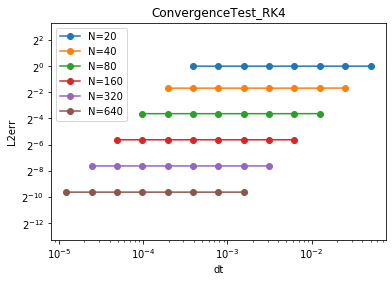

In [8]:
def RK4_Step(t, u, F, dt, info):
    """"Perform one Runge-Kutta 4 step
    
       - t current time
       - u current solution
       - F function that computes the right-hand-side 'F' in 
            du/dt = F
         The caling sequence is F(t, u, info)
       - dt time-step
       - info extra information needed by the right-hand-side function 
       
    returns
       t_new, u_new
    """
    
    k1=dt*F(t, u, info)
    k2=dt*F(t+0.5*dt, u+0.5*k1, info)
    k3=dt*F(t+0.5*dt, u+0.5*k2, info)
    k4=dt*F(t+dt, u+k3, info)
    return (t+dt, u+k1/6.+k2/3.+k3/3.+k4/6.)

t_final=1.
errN={}  # error at fixed N  vs. CF
for N in [20, 40, 80, 160, 320, 640]:
    print("N=",N)
    errN[N]=[[], []]
    for CF in [0, -1, -2, -3, -4, -5, -6, -7]:
        t, u0, info = Setup_FD(N)
        t,u=Evolve(t,t_final,u0,calc_F,RK4_Step,2**CF,info)
        # L2-norm of error after advecting once through domain
        err=np.sqrt(np.dot(u-u0, u-u0)/N)
        errN[N][0].append(2**CF*info.dxmin)  # store time-step
        errN[N][1].append(err)            # store error
    plt.loglog(errN[N][0], errN[N][1], 'o-', basey=2., basex=10, label="N=%d"%N)  # plot!
plt.xlabel('dt')
plt.ylabel('L2err')
plt.title("ConvergenceTest_RK4")
plt.legend()
plt.ylim(1e-4, 10.)
plt.show()

In [302]:
#Task FD-6
#Repeat with higher spatial order

# 2. pseudo-spectral method

In [303]:
def Setup_PS(N):
    """Perform the necessary setup for a pseudospectral 
    evolution on 'N' grid-points. 

    returns 
        t, u, info
        
    where
      - t=0.  the initial time
      - u the solution at t=0 (i.e. the initial guess)
      - info a tuple containing
         - info.dxmin minimal grid-spacing
         - info.x an array of grid-points"""

    # storage for extra info
    PS_Info_t=collections.namedtuple('PS_Info_t', 'dxmin, x')
    x = np.linspace(x_min, x_max, N, endpoint=False)
    info=PS_Info_t(dxmin=(x_max-x_min)/N, x=x)
    u = AnalyticSolution(x, 0.)
    return 0., u, info

In [304]:
#Task PS-1

def SpectralCoefficients(u):
    """Given data u, at uniformly distributed grid-points
    0<=x<1,  perform a decomposition into a spectral series
    returns complex array c, such that
      c[0] = real = **two** times average of data
      c[k].real * cos(2 pi k x) + c[k].imag * sin(2 pi k x)
    """
    c=np.fft.rfft(u)
    # adjust signs and magnitudes
    c = (2./len(u))*np.conj(c)
    return c 

#check
u=np.sin(4*np.pi*x)-(1/6)*np.cos(8*np.pi*x)
coeff=SpectralCoefficients(u)
coeff[2], coeff[4]

((-8.68749516769185e-17+1j), (-0.16666666666666657+4.767972011070004e-17j))

In [305]:
#Task PS-2

def PhysicalValues(c):
    
    """Given spectral coefficients A[k], reconstruct the function
   0.5*c[0] + Sum_k(  c[k].real * cos(2 pi k x)
                    + c[k].imag * sin(2 pi k x)
                   )
    """
    
    u = np.fft.irfft(np.conj(c))
    u = u * 0.5*len(u)
    return u

In [306]:
#Task PS-3

def calcF_PS(t,u,info):
    """Computes RHS F[u(x,t)] of the advection equation
    using pseudo-spectral methods with periodic BCs."""
    
    c=SpectralCoefficients(u)
    
    # multiply c[k] by -2 pi j k, where j is the imagimnary unit
    # the '2pi' arises because we chose 0<x<1 as interval
    # the '-' arises because of our convention c_k = a_k + j b_k
    k= np.linspace(0, len(c)-1, len(c))
    c *= 2*np.pi*(0-1j)*k
    # convert back to real-space values
    dudx=PhysicalValues(c)
    return -dudx

4
8
12
16
20
24
28
32


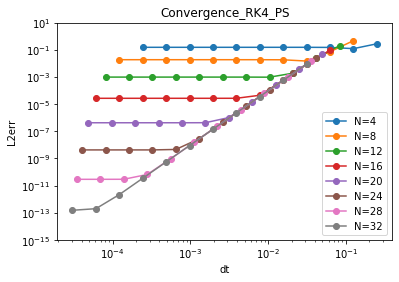

In [307]:
#Task PS-4 *convergence test - RK4*

t_final=1.02
errN={}  # error at fixed N  vs. CF
for N in [4,8,12,16,20,24,28,32]:
    print(N)
    errN[N]=[[], []]
    for CF in [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10]:
        t, u0, info = Setup_PS(N)
        t,u=Evolve(t, t_final, u0, calcF_PS, RK4_Step, 2**CF, info)
        # L2-norm of error after advecting once through domain
        uf=AnalyticSolution(t_final, info.x)
        err=np.sqrt(np.dot(u-uf, u-uf)/N)
        errN[N][0].append(2**CF*info.dxmin)  # store time-step
        errN[N][1].append(err)            # store error
    plt.loglog(errN[N][0], errN[N][1], 'o-', basex=10, label="N=%d"%N)  # plot!
plt.xlabel('dt')
plt.ylabel('L2err') 
plt.title("Convergence_RK4_PS")
plt.legend()
plt.ylim(1e-15, 10.)
plt.show()

4
8
12
16
20
24
28
32


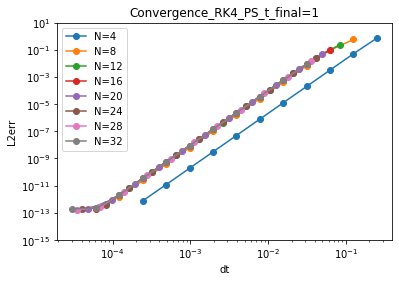

In [308]:
# Task PS-5

t_final=1.
errN={}  # error at fixed N  vs. CF
for N in [4,8,12,16,20,24,28,32]:
    print(N)
    errN[N]=[[], []]
    for CF in [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10]:
        t, u0, info = Setup_PS(N)
        t,u=Evolve(t, t_final, u0, calcF_PS, RK4_Step, 2**CF, info)
        # L2-norm of error after advecting once through domain
        uf=AnalyticSolution(t_final, info.x)
        err=np.sqrt(np.dot(u-uf, u-uf)/N)
        errN[N][0].append(2**CF*info.dxmin)  # store time-step
        errN[N][1].append(err)            # store error
    plt.loglog(errN[N][0], errN[N][1], 'o-', basex=10, label="N=%d"%N)  # plot!
plt.xlabel('dt')
plt.ylabel('L2err') 
plt.title("Convergence_RK4_PS_t_final=1")
plt.legend()
plt.ylim(1e-15, 10.)
plt.show()

# 3. Discontinuous Galerkin

In [9]:
def ReferenceElement(N):
    """Given the polynomial order N, initialize quantites of a reference-element
    in logical coordinate -1<=r<=1."""
    
    # Legendre polynomials are Jacobi(alpha,beta) polynomials
    alpha=0.; beta=0;

    # Gauss-Lobatto quadrature points for Legendre polynomials
    # According to Hesthaven+Warburton (p. 448, JacobGL.m) these
    # are the order N-2 Gauss quadrature points of Jacobi polynomials
    # with different alpha, beta, enlarged by end-points -1, +1. 
    #
    # note len(r)=N+1, i.e. matrices defined below (V, Vr, etc) are square
    if(N==1):
        r=np.array([-1.,1.])
    else:
        # (N-2)-th order quadrature points are roots of (N-1)-st Jacobi polynomial
        inner_roots, inner_weights = scipy.special.roots_jacobi(N-1, alpha+1, beta+1)
        r = np.concatenate([ [-1.], inner_roots, [1.] ])

    # Vandermonde matrix for Legendre polynomials
    # V[i,j] = P_j(r_i),  j=0,...,N,  i=0,...,len(r)-1
    V = np.zeros( (len(r), N+1))
    for j in range(N+1):
        # scipy normalization determined by trial and error.  
        # For **LAGRANGE POLY** ONLY, not general alpha, beta.
        # This makes the returned polynomials orthonormal
        normalization = np.sqrt((1.+2.*j)/2.)
        V[:,j] = scipy.special.eval_jacobi(j, alpha, beta, r)*normalization
        # or V[:,j] = scipy.special.legendre(j)(r)

        # check normalization
        # tmp_r, tmp_w = scipy.special.roots_jacobi(j+1, alpha, beta)
        # tmp_L=scipy.special.eval_jacobi(j, alpha, beta, tmp_r)*normalization
        # L_dot_L = sum(tmp_w*tmp_L*tmp_L)
        # print("j={}, (L,L)={}".format(j, L_dot_L))

    
    Vinv=np.linalg.inv(V)
        
    # derivatives of Legendre polynomials, evaluated at quadrature points
    # Vr[i,j] = dP_j/dr(r_i),  j=0,...,N,  i=0,...,len(r)-1
    #   use dP_j/dr = sqrt(j(j+1)) J^{alpha+1,beta+1}_{j-1}  (H+W, Eq A2)
    #   
    Vr = np.zeros( (len(r), N+1))
    for j in range(1,N+1):
        # scipy normalization determined by trial and error.  
        # For **LAGRANGE POLY** ONLY, not general alpha, beta.
        # This makes the returned polynomials orthonormal, conforming
        # to H+W conventions
        scipy_normalization=np.sqrt((1.+2.*j)*(j+1.)/(8.*j))
        normed_J = special.jacobi(j-1, alpha+1, beta+1)(r)*scipy_normalization
        Vr[:,j] = np.sqrt(j*(j+alpha+beta+1.))*normed_J  # H+W Eq. A2

        # - check normalization
        # - integrate by Legendre quadrature, to explicitly show weight-function in orthogonality 
        # tmp_r, tmp_w = scipy.special.roots_jacobi(j+4, alpha, beta)
        # tmp_L=scipy.special.eval_jacobi(j-1, alpha+1, beta+1, tmp_r)*scipy_normalization
        # - evaluate orthogonality; note weight function (1-r)(1+r)
        # L_dot_L = sum(tmp_w*tmp_L*tmp_L*(1-tmp_r)*(1+tmp_r))
        # print("j={}, (L,L)={}".format(j, L_dot_L))

    
    # derivatives of Lagrange interpolating polynomials 
    #    Dr(i,j) = dl_j/dr(r=r_i), 
    # where  l_j(r_i) = delta_{ij}
    # compute using P_j(r) = V[i,j]*l_i(r) =>  V[i,j] dl_i/dr = dP_j/dr     (*)
    #     => V^{-T} V^T[j,i] dl_i/dr = V^{-T} dP_j/dr 
    Dr = np.matmul(Vr,Vinv)
    
    # inverse of mass-matrix
    # Using (*), one can show  M = (V V^T)^(-1)
    # Turns out that the inverse of M is used in the DG algorithm,
    # and so we can directly compute M-inverse, without computing
    # matrix-inverses:
    Minv = np.matmul(V, V.transpose())
    
    # finally, M^{-1}S = Dr, and since we need S only multiplied by M^{-1},
    # we can just return Dr
    MinvS=Dr
    
    return r, Minv, MinvS

# replicate Hesthaven + Warburton, Fig. 3.4
r, Minv, MinvS=ReferenceElement(4)
np.set_printoptions(formatter={'float': lambda x: "%.3f"%x})
print(MinvS)

[[-5.000 6.757 -2.667 1.410 -0.500]
 [-1.241 0.000 1.746 -0.764 0.259]
 [0.375 -1.337 0.000 1.337 -0.375]
 [-0.259 0.764 -1.746 0.000 1.241]
 [0.500 -1.410 2.667 -6.757 5.000]]


In [10]:
#Task DG-1

def Advect_Info_DG(K, N, xmin, xmax, alpha):
    """collects all info needed to evaluate the DG rhs for the Advection problem.
    Input parameters:
      K    - number of elements
      N    - polynomial order
      xmin,xmax - overall interval
      alpha - coefficient in DG flux

    Returns namedtuple with the following entries
      N     - polynomial order
      Np    - points per element
      K     - number of elements
      xmin, xmax - overall interval
      h     - width of each element
      r_ref - reference element points (i.e. r[0]=-1.  ... r[N]=+1. )
      Minv_ref, MinvS_ref -- reference element matrices
      alpha - coefficent in DG flux
      x     - total set of collocation points (for setting initial data)
      dxmin - minimal grid-spacing
      x_k   - collocation points at boundaries (for plotting) length K+1"""
    
    Np=N+1

    h=(xmax-xmin)/K
    AdvectInfo_t=collections.namedtuple('AdvectInfo_t', 
            'N, Np, K, r_ref, Minv_ref, MinvS_ref, h, xmin, xmax, alpha, x, dxmin, x_k')
    
    r, Minv, MinvS = ReferenceElement(N)
    dr=r[1:]-r[:-1]
    dxmin = min(dr)*h/2
    x_k=np.linspace(xmin, xmax, K+1)
    x=np.zeros([K*Np])
    for k in range(K):
        x[k*Np:(k+1)*Np]=xmin+k*h+h*(r+1.)/2.
    
    info=AdvectInfo_t(N=N, Np=Np, K=K, xmin=xmin, xmax=xmax, h=h, 
                    r_ref=r, Minv_ref=Minv, MinvS_ref=MinvS, alpha=alpha, 
                    x=x, dxmin=dxmin, x_k=x_k)
    return info

In [11]:
def Setup_DG(K, N, alpha):
    """Perform the necessary setup for a pseudospectral 
    evolution on 'K' domains, each with N' grid-points. 

    returns 
        t, u, info
    where
      - t=0.  the initial time
      - u the solution at t=0 (i.e. the initial guess)
      - info is described in Advect_Info_DG
      """
    info=Advect_Info_DG(K, N, 0., 1., alpha)
    u = AnalyticSolution(info.x, 0.)
    return 0., u, info

In [12]:
#Task DG-2, DG-3

def AdvectRHS_DG(t, u, info):
    """Given a vector of length K*(N+1) of all grid-point values, compute the rhs of the DG advection problem"""

    periodic_BC = True
    
    # convenient variables
    N  = info.N   # highest polynomial order
    Np = info.Np  # number of points per element
    K  = info.K
    alpha = info.alpha
    
    # geometrically rescaled matrices
    MinvS = 2/info.h*info.MinvS_ref
    Minv = 2/info.h*info.Minv_ref
    
    dudt = 0.*u
    
    # compute flux on all elements
    f = u  # **right**-moving with speed 1.
    
    # volume terms
    for k in range(K):
        #print(shape(MinvS), ', ', shape(f[k*Np:(k+1)*Np]),
        #          ', ', shape(MinvS*f[k*Np:(k+1)*Np]))
                                          
        dudt[k*Np:(k+1)*Np] = -np.matmul(MinvS,f[k*Np:(k+1)*Np])  #  + g(..),  but g=0
  
    # internal boundaries
    for k in range(0,K-1):
        uminus=u[(k+1)*Np-1]
        uplus=u[(k+1)*Np]
        flux = (uminus+uplus)/2. + (1-alpha)/2.*(uminus - uplus)
        
        # insert into upper boundary of element k
        dudt[k*Np:(k+1)*Np]     += -Minv[:,N] * (flux-f[(k+1)*Np-1])
        # insert into lower bounary of element k+1
        dudt[(k+1)*Np:(k+2)*Np] +=  Minv[:,0] * (flux - f[(k+1)*Np])

    # periodic boundary conditions to connect D^0 to D^{K-1}
    # same formulae as just above, except for indexing
    if periodic_BC:
        uminus=u[K*Np-1]  # upper edge of D^{K-1}}
        uplus=u[0]        # lower edge of D^0
        flux = (uminus+uplus)/2. + (1-alpha)/2.*(uminus - uplus)

        # insert into upper boundary of element K-1
        dudt[(K-1)*Np:K*Np]     += -Minv[:,N] * (flux-f[K*Np-1])
        # insert into lower bounary of element k+1 (i.e. D^0)
        dudt[0:Np] +=  Minv[:,0] * (flux - f[0])
    else:
        raise NameError('non-period BCs not yet implemented')

    return dudt

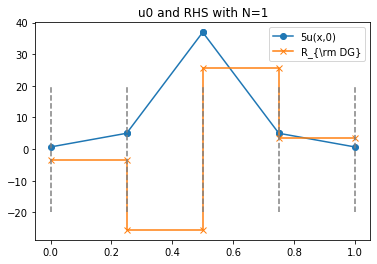

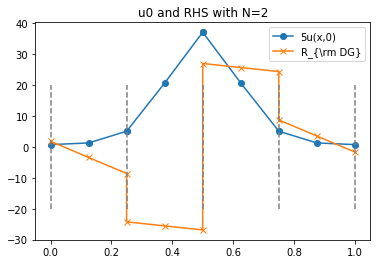

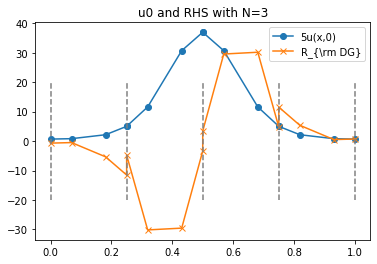

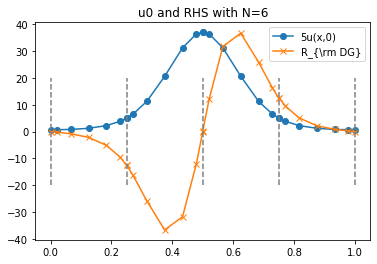

In [13]:
#plot 
for N  in [1,2,3,6]:
    fig=plt.figure()
    t, u, info=Setup_DG(4,N, 0.5)
    dudt=AdvectRHS_DG(t, u, info)
    plt.plot(info.x, 5*u,'-o', label='5u(x,0)')
    plt.plot(info.x, dudt, '-x', label='R_{\\rm DG}')
    for x in info.x_k: 
        plt.plot([x,x],[-20,20],'--', color='grey')
    plt.title('u0 and RHS with N=%d'%N)
    plt.legend()
    fig.savefig('AdvectDG_RHS_K%d_N%d.png'%(4, N))

In [18]:
#Task DG-4

def ConvgTest_DG(K_choices, N_choices, CF):
    """Perform a convergence test with DG, running
    on all combination of N_choices x K_choices, and
    with Courant factor 'CF;' 
    returns
      errN dictionary, s.t. errN[N] contains err vs. K at this N"""

    # convergence test - RK4
    t_final=1.0

    errN={}
    for N in N_choices:
        #print(N)
        print("N=%d, CF=%f"%(N,2**CF))
        errN[N]=[[],[]]
        for K in K_choices:
            t, u0, info = Setup_DG(K,N, 0.5)
            t, u = Evolve(t, t_final, u0, AdvectRHS_DG, RK4_Step, 2**CF, info)

            # L2-norm of error after advecting once through domain
            uf=AnalyticSolution(t_final, info.x)
            err=np.sqrt(np.dot(u-uf, u-uf)/len(u))
            if(N==1 and K<=2): 
                continue # avoid one divergent point
            errN[N][0].append(K)
            errN[N][1].append(err)
            if K>=6 and errN[N][1][-2]<err: 
                # stop if error is increasing
                break
    return errN

N=1, CF=0.007812
N=2, CF=0.007812
N=4, CF=0.007812
N=6, CF=0.007812
N=8, CF=0.007812
N=10, CF=0.007812
N=1, CF=0.015625
N=2, CF=0.015625
N=4, CF=0.015625
N=6, CF=0.015625
N=8, CF=0.015625
N=10, CF=0.015625


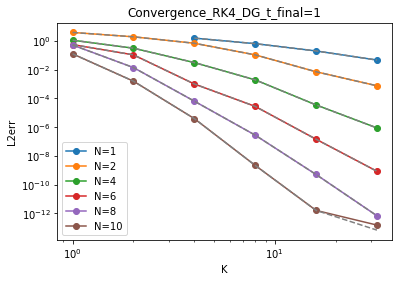

In [20]:
# run convergence test, plot error vs. K for different N
# use two different CF's to verify that time-stepping error
# is irrelevant

CF1=-7
CF2=-6
K_choices=[1,2,4,8,16,32]
N_choices=[1,2,4,6,8,10]
err_C1 = ConvgTest_DG(K_choices, N_choices, CF1)
err_C2 = ConvgTest_DG(K_choices, N_choices, CF2)

for N in err_C1.keys():
    k=err_C1[N][0]
    y=err_C1[N][1]
    plt.loglog(k,y, 
               label="N={}".format(N), 
               marker='o', linestyle='-')
for N in err_C2.keys():
    plt.loglog(err_C2[N][0], err_C2[N][1],  
               linestyle='--', color='gray')

plt.xlabel('K')
plt.ylabel('L2err') 
plt.title("Convergence_RK4_DG_t_final=1")
plt.legend()